# Machine Learning A4
#### Author: Logan Fouts (lf222yv)
## Exercise 1: Clustering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans


def sse(cluster):
    """
    Calculates the SSE for given cluster.

    Params:
        cluster (np array): The cluster in which to find the SSE.
    
    Return:
        float: SSE value for the cluster.
    """
    clustMean = np.mean(cluster, axis=0)
    squareErr = (cluster - clustMean) ** 2
    sse = np.sum(squareErr)

    return sse


def bkmeans(X, k, iter):
    """
    Executes Bisecting k-means clustering with provided arguments.

    Parameters:
        X (numpy array): Data to perform clustering on.
        k (int): Number of differnt clusters to seperate out.
        iter (int): Number of times to iterate inside of K means.
    Return:
        numpy array: n x 1 vector with cluster indices for each of the observations.
    """
    # Single cluster containing all observations.
    clusters = [X]

    # Bisecting k-Means.
    while len(clusters) < k:
        # Find cluster with the largest SSE.
        largestSSE_cluster = clusters[0]
        largestSSE = sse(clusters[0])

        for cluster in clusters[1:]:
            tmpSSE = sse(cluster)
            if tmpSSE > largestSSE:
                largestSSE = tmpSSE
                largestSSE_cluster = cluster
        
        # K-Means on the cluster from above.
        kmeans = KMeans(n_clusters=2, n_init=iter)
        kmeans.fit(largestSSE_cluster)
        labels = kmeans.labels_
        
        # Split into two clusters.
        subClust1 = largestSSE_cluster[labels == 0]
        subClust2 = largestSSE_cluster[labels == 1]
        
        # Remove largest cluster add two subclusters.
        tmp_clusters = []
        for cluster in clusters:
            if not np.array_equal(cluster, largestSSE_cluster):
                tmp_clusters.append(cluster)
        clusters = tmp_clusters
        clusters.append(subClust1)
        clusters.append(subClust2)

    # Assign cluster indices for data points.
    cluster_indices = np.zeros(X.shape[0])
    for i, cluster in enumerate(clusters):
        indices = np.isin(X, cluster).all(axis=1)
        cluster_indices[indices] = i

    return cluster_indices.reshape([-1, 1])

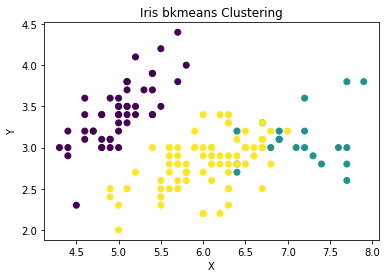

In [2]:
################################ Testing ################################
iris = datasets.load_iris()
X = iris.data

k = 3
iterations = 10
cluster_indices = bkmeans(X, k, iterations)

plt.scatter(X[:, 0], X[:, 1], c=cluster_indices)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Iris bkmeans Clustering')
plt.show()

## Exercise 2: Non-linear Dimensionality Reduction

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets


def compute_gradient(Y, X):
    """
    Calculates the gradient for a given sammon mapping.

    Arguments:
        Y (numpy array): Config of points.
        data (numpy array): Original points.

    Return:
        numpy array: Gradient of sammon mapping.
    """
    s = Y.shape[0]
    distY = np.sqrt(np.sum((Y[:, np.newaxis] - Y) ** 2, axis=2))
    distD = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, axis=2))
    grade = np.zeros(Y.shape)
    
    for i in range(s):
        tmpY = Y[i] - Y
        dataChange = X[i] - X
        tmpY[i] = 0
        dataChange[i] = 0
        # Be careful with division by zero.
        deriveE = (distY[i] - distD[i]) / ((distY[i] * distD[i]) + 1e-8)
        grade[i] = np.sum(tmpY * deriveE[:, np.newaxis], axis=0)

    return (grade * (2 / s))

def compute_stress(Y, X):
    """
    Computes stress for given sammon mapping.

    Arguments:
        Y (numpy array): Config of points.
        data (numpy array): Original points.

    Return:
        float: Current stress of sammon mapping.
    """
    distY = np.linalg.norm(Y[:, np.newaxis] - Y, axis=2)
    distD = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
    stress = np.mean((distY - distD) ** 2)

    return stress

def sammon(X, iter=500, e=1e-7, a=.1):
    """
    Implements sammon mapping given a set of data and optionally 3 other parameters.

    Arguments:
        X (numpy array): Data to reduce, as an n x p matrix (n observations by p features).
        iter (int): Maximum number of iterations.
        e (float): Error threshold.
        a (float): Learning rate.
    
    Return:
        numpy array: A n x 2 vector with the final two-dimensional layout.
    """
    # 1. Start with a random two-dimensional layout Y of points (Y is a n × 2 matrix).
    Y = np.random.rand(X.shape[0], 2)

    # 2. Compute the stress E of Y.
    E = compute_stress(Y, X)

    # 3. If E < epsilon, or if the maximum number of iterations iterations has been reached, stop.
    for i in range(iter):
        if E < e:
            break
    # 4. For each yi of Y, find the next vector yi(t + 1) based on the current yi(t).
        gradient = compute_gradient(Y, X)
        Y -= a * gradient
        E = compute_stress(Y, X)
    
    return Y

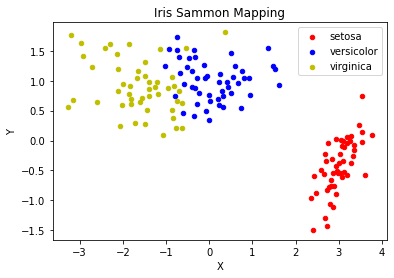

In [4]:
################################ Testing ################################
iris = datasets.load_iris()
(x,index) = np.unique(iris.data,axis=0,return_index=True)
target = iris.target[index]
names = iris.target_names
np.random.seed(0)

iter = 100
e = 1e-7
a = 1
y = sammon(x, iter, e, a)

plt.scatter(y[target ==0, 0], y[target ==0, 1], s=20, c='r',label=names[0])
plt.scatter(y[target ==1, 0], y[target ==1, 1], s=20, c='b',label=names[1])
plt.scatter(y[target ==2, 0], y[target ==2, 1], s=20, c='y',label=names[2])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Iris Sammon Mapping')
plt.show()

## Exercise 3: Visualization of Results
### 3.1 (Comparison of DR Techniques)

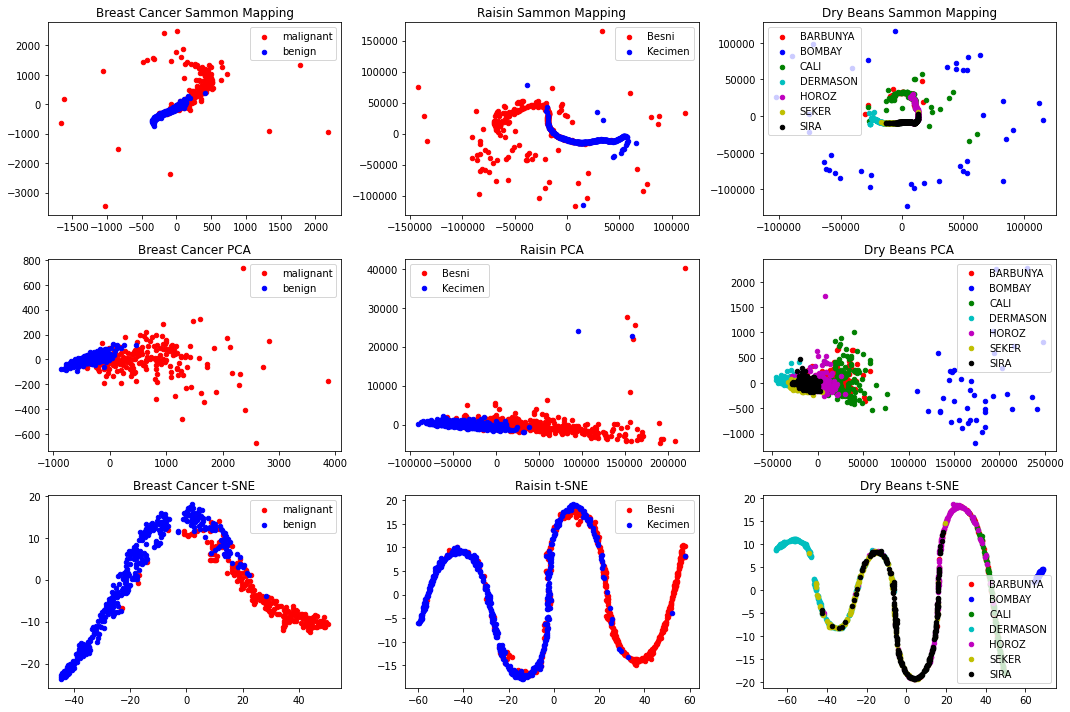

In [5]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load Datasets
subset_size = 1000

bc = datasets.load_breast_cancer()
(bcX, index) = np.unique(bc.data, axis=0, return_index=True)
bcTarget = bc.target[index]
bcNames = bc.target_names

data = pd.read_excel("Data/Raisin_Dataset.xlsx")
raisinX = data.drop("Class", axis=1).values
raisinTarget = data["Class"].values

data = pd.read_excel("Data/Dry_Bean_Dataset.xlsx")
beanSubset = data.sample(n=subset_size, random_state=42)
beanX = beanSubset.drop("Class", axis=1).values
beanTarget = beanSubset["Class"].values

# Run Sammon Mapping for each dataset
iter = 100
e = 1e-7
a = 100
bcResult = sammon(bcX, iter, e, a)
iter = 100
e = 1e-7
a = 2000
raisinResult = sammon(raisinX, iter, e, a)
iter = 100
e = 1e-7
a = 1000
beanResult = sammon(beanX, iter, e, a)

# Run PCA for each dataset
pca = PCA(n_components=2)
bcPcaResult = pca.fit_transform(bcX)
raisinPcaResult = pca.fit_transform(raisinX)
beanPcaResult = pca.fit_transform(beanX)

# Run t-SNE for each dataset
tsne = TSNE(n_components=2, random_state=42)
bcTsneResult = tsne.fit_transform(bcX)
raisinTsneResult = tsne.fit_transform(raisinX)
beanTsneResult = tsne.fit_transform(beanX)

############################## Plotting ##############################

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

########## Sammon Mapping ##########

axs[0, 0].scatter(bcResult[bcTarget == 0, 0], bcResult[bcTarget == 0, 1], s=20, c='r', label=bcNames[0])
axs[0, 0].scatter(bcResult[bcTarget == 1, 0], bcResult[bcTarget == 1, 1], s=20, c='b', label=bcNames[1])
axs[0, 0].set_title('Breast Cancer Sammon Mapping')
axs[0, 0].legend()

targetClasses = np.unique(raisinTarget)
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
for i, target in enumerate(targetClasses):
    indices = raisinTarget == target
    axs[0, 1].scatter(raisinResult[indices, 0], raisinResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[0, 1].set_title('Raisin Sammon Mapping')
axs[0, 1].legend()

target_labels = np.unique(beanTarget)
for i, target in enumerate(target_labels):
    indices = beanTarget == target
    axs[0, 2].scatter(beanResult[indices, 0], beanResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[0, 2].set_title('Dry Beans Sammon Mapping')
axs[0, 2].legend()

########## PCA ##########

axs[1, 0].scatter(bcPcaResult[bcTarget == 0, 0], bcPcaResult[bcTarget == 0, 1], s=20, c='r', label=bcNames[0])
axs[1, 0].scatter(bcPcaResult[bcTarget == 1, 0], bcPcaResult[bcTarget == 1, 1], s=20, c='b', label=bcNames[1])
axs[1, 0].set_title('Breast Cancer PCA')
axs[1, 0].legend()

for i, target in enumerate(targetClasses):
    indices = raisinTarget == target
    axs[1, 1].scatter(raisinPcaResult[indices, 0], raisinPcaResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[1, 1].set_title('Raisin PCA')
axs[1, 1].legend()

for i, target in enumerate(target_labels):
    indices = beanTarget == target
    axs[1, 2].scatter(beanPcaResult[indices, 0], beanPcaResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[1, 2].set_title('Dry Beans PCA')
axs[1, 2].legend()

########## t-SNE ##########

axs[2, 0].scatter(bcTsneResult[bcTarget == 0, 0], bcTsneResult[bcTarget == 0, 1], s=20, c='r', label=bcNames[0])
axs[2, 0].scatter(bcTsneResult[bcTarget == 1, 0], bcTsneResult[bcTarget == 1, 1], s=20, c='b', label=bcNames[1])
axs[2, 0].set_title('Breast Cancer t-SNE')
axs[2, 0].legend()

for i, target in enumerate(targetClasses):
    indices = raisinTarget == target
    axs[2, 1].scatter(raisinTsneResult[indices, 0], raisinTsneResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[2, 1].set_title('Raisin t-SNE')
axs[2, 1].legend()

for i, target in enumerate(target_labels):
    indices = beanTarget == target
    axs[2, 2].scatter(beanTsneResult[indices, 0], beanTsneResult[indices, 1], s=20, c=colors[i], label=str(target))
axs[2, 2].set_title('Dry Beans t-SNE')
axs[2, 2].legend()

plt.tight_layout()
plt.show()

#### 3.1 Response:
In my analysis, I found that the sammon mapping method performed exceptionally well for the Breast Cancer dataset, while PCA yielded impressive results for the raisin dataset. In the case of the Dry Beans dataset, t-SNE emerged as the most effective technique.

My conclusion was based on careful consideration of how the classes are separated and the inherent structure of the data. For instance, the complex and nonlinear nature of the Breast Cancer dataset made sammon mapping the ideal choice, as it excels at preserving local relationships, which is crucial for accurate cancer classification. In contrast, the linear structure of the raisin dataset made PCA the preferred method, as it specializes in capturing global variance in such data.

Considering the Dry Beans dataset, I found it to be particularly challenging due to the close proximity and overlapping nature of the classes, resulting in ambiguous boundaries. Nonetheless, t-SNE proved to be the most effective in navigating this complexity and revealing meaningful class separations. Specifically, the Bombay and Dermason classes appeared less clustered compared to others, making them relatively easier to distinguish within the Dry Beans dataset.

### 3.2 (Comparison of Clustering Techniques)

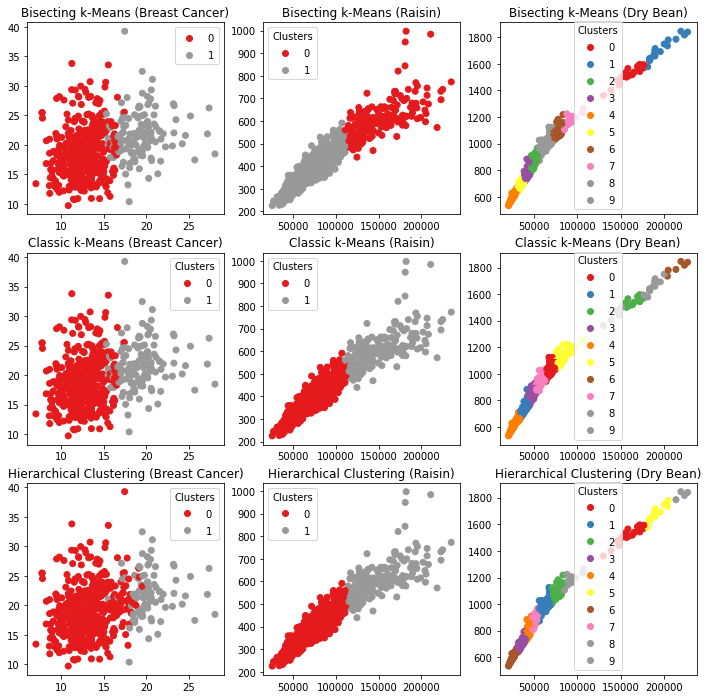

In [6]:
from sklearn.cluster import AgglomerativeClustering

# Load Data
subset_size = 1000

bc = datasets.load_breast_cancer()
(bcX, index) = np.unique(bc.data, axis=0, return_index=True)
bcTarget = bc.target[index]
bcNames = bc.target_names

raisin_data = pd.read_excel("Data/Raisin_Dataset.xlsx")
raisinX = raisin_data.drop("Class", axis=1).values
raisinTarget = raisin_data["Class"].values

bean_data = pd.read_excel("Data/Dry_Bean_Dataset.xlsx")
beanSubset = bean_data.sample(n=subset_size, random_state=42)
beanX = beanSubset.drop("Class", axis=1).values
beanTarget = beanSubset["Class"].values

########## Run For: Breast Cancer Set ##########
bc_bkmeans_labels = bkmeans(bcX, k=2, iter=100)

bc_kmeans = KMeans(n_clusters=2, n_init="auto")
bc_kmeans_labels = bc_kmeans.fit_predict(bcX)

bc_hierarchical = AgglomerativeClustering(n_clusters=2)
bc_hierarchical_labels = bc_hierarchical.fit_predict(bcX)

########## Run For: Raisin Set ##########
raisin_bkmeans_labels = bkmeans(raisinX, k=2, iter=100)

raisin_kmeans = KMeans(n_clusters=2, n_init="auto")
raisin_kmeans_labels = raisin_kmeans.fit_predict(raisinX)

raisin_hierarchical = AgglomerativeClustering(n_clusters=2)
raisin_hierarchical_labels = raisin_hierarchical.fit_predict(raisinX)

########## Run For: Dry Beans Set ##########
bean_bkmeans_labels = bkmeans(beanX, k=10, iter=100)

bean_kmeans = KMeans(n_clusters=10, n_init="auto")
bean_kmeans_labels = bean_kmeans.fit_predict(beanX)

bean_hierarchical = AgglomerativeClustering(n_clusters=10)
bean_hierarchical_labels = bean_hierarchical.fit_predict(beanX)


############################## Plotting ##############################
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

qual_col_map = 'Set1'

scatter = axes[0, 0].scatter(bcX[:, 0], bcX[:, 1], c=bc_bkmeans_labels, cmap=qual_col_map)
axes[0, 0].set_title("Bisecting k-Means (Breast Cancer)")
axes[0, 0].legend(*scatter.legend_elements())

scatter = axes[0, 1].scatter(raisinX[:, 0], raisinX[:, 1], c=raisin_bkmeans_labels, cmap=qual_col_map)
axes[0, 1].set_title("Bisecting k-Means (Raisin)")
axes[0, 1].legend(*scatter.legend_elements(), title='Clusters')

scatter = axes[0, 2].scatter(beanX[:, 0], beanX[:, 1], c=bean_bkmeans_labels, cmap=qual_col_map)
axes[0, 2].set_title("Bisecting k-Means (Dry Bean)")
axes[0, 2].legend(*scatter.legend_elements(), title='Clusters')

scatter = axes[1, 0].scatter(bcX[:, 0], bcX[:, 1], c=bc_kmeans_labels, cmap=qual_col_map)
axes[1, 0].set_title("Classic k-Means (Breast Cancer)")
axes[1, 0].legend(*scatter.legend_elements(), title='Clusters')

scatter = axes[1, 1].scatter(raisinX[:, 0], raisinX[:, 1], c=raisin_kmeans_labels, cmap=qual_col_map)
axes[1, 1].set_title("Classic k-Means (Raisin)")
axes[1, 1].legend(*scatter.legend_elements(), title='Clusters')

scatter = axes[1, 2].scatter(beanX[:, 0], beanX[:, 1], c=bean_kmeans_labels, cmap=qual_col_map)
axes[1, 2].set_title("Classic k-Means (Dry Bean)")
axes[1, 2].legend(*scatter.legend_elements(), title='Clusters')

scatter = axes[2, 0].scatter(bcX[:, 0], bcX[:, 1], c=bc_hierarchical_labels, cmap=qual_col_map)
axes[2, 0].set_title("Hierarchical Clustering (Breast Cancer)")
axes[2, 0].legend(*scatter.legend_elements(), title='Clusters')

scatter = axes[2, 1].scatter(raisinX[:, 0], raisinX[:, 1], c=raisin_hierarchical_labels, cmap=qual_col_map)
axes[2, 1].set_title("Hierarchical Clustering (Raisin)")
axes[2, 1].legend(*scatter.legend_elements(), title='Clusters')

scatter = axes[2, 2].scatter(beanX[:, 0], beanX[:, 1], c=bean_hierarchical_labels, cmap=qual_col_map)
axes[2, 2].set_title("Hierarchical Clustering (Dry Bean)")
axes[2, 2].legend(*scatter.legend_elements(), title='Clusters')

plt.show()

#### 3.2 Response:

In my opinion, the Bisecting k-Means algorithm performed the best for all the selected datasets. Although the results for each clustering method were quite similar, I chose Bisecting k-Means because it required less computational power to run. The clustering methods used in the analysis were successful in separating the classes, and the resulting clusters were generally clear and distinct. Comparatively, the clustering process seemed to yield clearer clusters than the dimensionality reduction techniques employed earlier. This is most liekly because clustering algorithms are specifically designed to group similar instances together, making them more effective for class separation tasks. In contrast, DR techniques focus on reducing dimensionality and preserving information rather than explicitly separating classes.